In [27]:


import pandas as pd

# fead all the files in the folder results
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pickle
import json

# open config

# open the file
with open("config.json", "r") as file:
    config = json.load(file)


folders = os.listdir("Results")

for folder in folders:
    path = "Results/"+folder+"/NeuroSim_Results_Each_Epoch"
    files = os.listdir(path)
    if(len(files) == 0):
        continue
    with open("Results/" + folder + "/arch.pkl", 'rb') as file:
        input = pickle.load(file)
    
    
    # create input to numpy array
    input = np.array(input)
    
    with open(path +"/NeuroSim_Breakdown_Epock_0.csv", 'r') as file:
        csv_content = file.read()
        delimiter = "\n\n"  # Replace this with the appropriate delimiter/pattern
        csv_file = StringIO(csv_content.split(delimiter)[1])
        df = pd.read_csv(csv_file)
        latency = (df[' latency_FW(s)'])[:-1]
        energy = (df[' energy_FW(J)'])[:-1]
        
        
        latency = np.array(latency)
        energy = np.array(energy)
        if len(latency) < config["output_size"]:
            # pad with zeroes
            latency = np.pad(latency, (0, config["output_size"]-len(latency)), 'constant')
            energy = np.pad(energy, (0, config["output_size"]-len(energy)), 'constant')
        if(latency.dtype == np.object or energy.dtype == np.object):
            continue
        if not os.path.exists("./dataset.pkl"):
            with open ("./dataset.pkl" , "wb") as file:
                pickle.dump([(input , (latency , energy))] , file)
        else : 
            with open ("./dataset.pkl" , "rb") as file:
                
                existing_data = pickle.load(file)
            with open ("./dataset.pkl" , "wb") as file:
                existing_data.append((input , (latency , energy)))
                pickle.dump(existing_data , file)
            


/tmp/ipykernel_233051/1843490698.py:48: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if(latency.dtype == np.object or energy.dtype == np.object):
/tmp/ipykernel_233051/1843490698.py:48: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if(latency.dtype == np.object or energy.dtype == np.object):
/tmp/ipykernel_233051/1843490698.py:48: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will

In [166]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader , TensorDataset
import numpy as np
import pickle
import json
# open the file
with open("config.json", "r") as file:
    config = json.load(file)

 
with open ("./dataset.pkl" , "rb") as file:
    data = pickle.load(file)
data = list(map(lambda x : (torch.tensor(x[0]) , torch.tensor(x[1])) , data))
# split the data into train and test
train_size = int(0.9 * len(data))
test_size = len(data) - train_size
train_data , test_data = torch.utils.data.random_split(data , [train_size , test_size])
train_data_loader = DataLoader(train_data , batch_size = 64 , shuffle = True)
test_data_loader = DataLoader(test_data , batch_size = 1 , shuffle = True)


In [167]:
print(len(train_data_loader))

2


In [168]:
# create a model

class Model(nn.Module):
    def __init__(self , input_size ,hidden_size, output_size):
        super(Model , self).__init__()
        self.fc1 = nn.Linear(input_size , hidden_size)
        
        self.fc2 = nn.Linear(hidden_size , hidden_size)
        self.fc3 = nn.Linear(hidden_size , output_size)
    def forward(self , x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x


model = Model(config["embedding_size"] , config["hidden_size"] ,2* config["output_size"])
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters() )


/tmp/ipykernel_233051/3138159418.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(i[0]).float()
/tmp/ipykernel_233051/3138159418.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(i[1]).squeeze(0).view(-1 ,20).float()


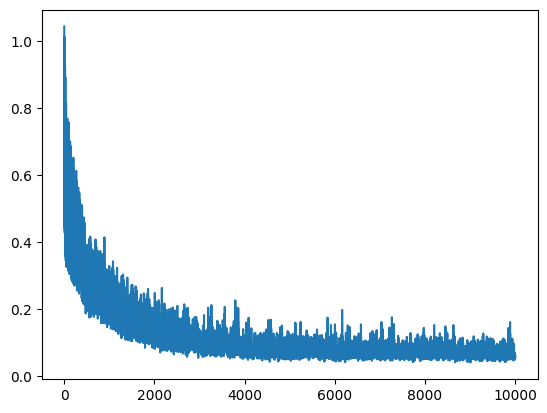

In [169]:
epocs = []
losses = []
for epoch in range(10000):
    model.train()
    totalloss = 0
    for i in train_data_loader:
        X = torch.tensor(i[0]).float()
        Y = torch.tensor(i[1]).squeeze(0).view(-1 ,20).float()
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output , Y)
        loss.backward()
        optimizer.step()
        totalloss += (loss.item()/ X.shape[0])
    losses = losses + [totalloss / len(train_data_loader)]
    epocs = epocs + [epoch]

# plot the loss
plt.plot(epocs , losses)
plt.show()


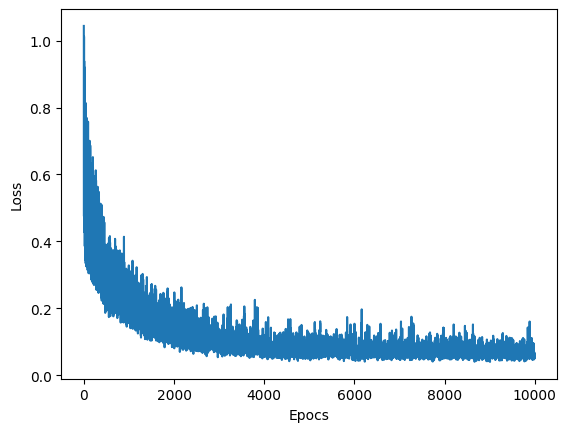

In [170]:
# plot the loss and label the axis 
plt.plot(epocs , losses)
plt.xlabel("Epocs")
plt.ylabel("Loss")
plt.show()



0.5
RMSE:  tensor(196.5074)
R^2:  tensor(0.7031)


/tmp/ipykernel_233051/2338413167.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(i[0]).float()
/tmp/ipykernel_233051/2338413167.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(i[1]).squeeze(0).view(-1 ,20).float()


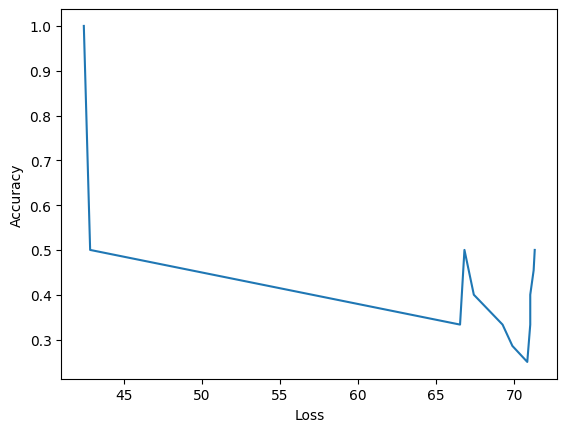

In [176]:
losses = []
epocs = []
model.eval()
count  = 0
ssm = 0
tss = 0
rms = 0
epoch = 1
with torch.no_grad():
    for i in test_data_loader:
        X = torch.tensor(i[0]).float()
        Y = torch.tensor(i[1]).squeeze(0).view(-1 ,20).float()
        output = model(X)
        loss = criterion(output , Y)
        # check the absolute difference is less than 0.01
        if torch.all(torch.abs(output - Y) < 10):
            count += 1
            
        # calculate the r^2 score
        ssm += torch.sum((output - Y)**2)
        tss += torch.sum((Y - torch.mean(Y))**2)
        totalloss += (loss.item()/ X.shape[0])
        # calcualte mean absolute percentage error
        
        losses = losses + [totalloss / len(train_data_loader)]
        epocs = epocs + [count / epoch]
        epoch += 1
        
        
    print(count /(len(test_data_loader) )) 
    print("RMSE: " , torch.sqrt(ssm/len(test_data_loader))  )
    print("R^2: " , 1 - ssm/tss)
    plt.plot(losses, epocs)
    plt.xlabel("Loss")
    plt.ylabel("Accuracy")
    plt.show()
    
    


In [177]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model.eval()

with torch.no_grad():
    y_true = []
    y_pred = []
    for i in test_data_loader:
        X = torch.tensor(i[0]).float()
        Y = torch.tensor(i[1]).squeeze(0).view(-1 ,20).float()
        output = model(X)
        y_true.extend(Y.numpy())
        y_pred.extend(output.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("R^2: ", r2_score(y_true, y_pred))
    print("MSE: ", mean_squared_error(y_true, y_pred))
    print("MAE: ", mean_absolute_error(y_true, y_pred))
    print("MAPE: ", mean_absolute_percentage_error(y_true, y_pred))

R^2:  0.30342968782896185
MSE:  1930.7585
MAE:  4.849038
MAPE:  0.4461555


/tmp/ipykernel_233051/3430876089.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(i[0]).float()
/tmp/ipykernel_233051/3430876089.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(i[1]).squeeze(0).view(-1 ,20).float()
